# Handling class imbalance for upset prediction

This notebook builds on the cleaned ATP betting-odds dataset where `upset_binary` labels rare upsets (≈6–8%) vs non-upsets. We will construct a robust, leakage-safe workflow to model these rare events.

In this step, we will:
- Outline the plan and metrics suited for rare events (PR-AUC, F1 for the upset class, MCC, balanced accuracy).
- Set up imports, configuration, and a path to the cleaned per-year Excel files exported previously.

Next steps (coming after this cell):
1) Load the cleaned data (per-year Excel files), validate required columns, and combine with a year column.
2) Explore class imbalance overall and by year.
3) Define time-aware splits (train: 2016–2022, val: 2023, test: 2024).
4) Train a baseline classifier with class weighting, evaluate rare-event metrics, then iterate with threshold tuning and calibration.

In [3]:
# Imports and configuration for imbalance-aware modeling
from pathlib import Path
import glob
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')

# Reproducibility
SEED = 42

# Path to cleaned, per-year Excel files exported from the prep notebook
DATA_DIR = Path(r"c:\\poly_code\\Cleaned_Data_Betting-odds")
print(f"Data directory: {DATA_DIR}")

# Peek at available files (we'll load them in the next step)
excel_files = sorted(DATA_DIR.glob('*.xlsx')) if DATA_DIR.exists() else []
print(f"Found {len(excel_files)} Excel files.")
if len(excel_files) == 0:
    print("Note: If no files are found, run the export step in the 'Betting-odds_upset_def' notebook or adjust DATA_DIR.")

Data directory: c:\poly_code\Cleaned_Data_Betting-odds
Found 9 Excel files.


## Load cleaned ATP data and validate

We now load the per-year Excel files exported previously, ensure the required modeling columns (including `upset_binary`) exist in each file, attach a `year` column, and concatenate into a single DataFrame for analysis. We keep this step read-only (no modeling yet).

In [5]:
# Load cleaned files, validate schema, and concatenate with year column
from pathlib import Path
import re

REQUIRED_COLS = [
    'Location','Tournament','Date','Series','Court','Surface','Round','Best of',
    'Winner','Loser','WRank','LRank','AvgW','AvgL','prob_winner','prob_loser','upset_binary'
 ]

assert 'DATA_DIR' in globals(), "DATA_DIR not defined. Run the setup cell above."
files = sorted(DATA_DIR.glob('*.xlsx')) if DATA_DIR.exists() else []
print(f"Found {len(files)} .xlsx files in {DATA_DIR}")
if not files:
    raise FileNotFoundError("No cleaned Excel files found. Ensure the export step ran and DATA_DIR is correct.")

# Filter out temporary/lock files (e.g., '~$cleaned_atp_2016.xlsx')
files = [fp for fp in files if not fp.name.startswith('~$')]
print(f"Using {len(files)} valid Excel files after filtering lock files.")

frames = []
years_seen = []
for fp in files:
    # Expect filenames like 'cleaned_atp_2019.xlsx' -> extract 4-digit year
    stem = fp.stem
    m = re.search(r'(19|20)\d{2}', stem)
    if not m:
        raise ValueError(f"Could not infer year from filename: {fp.name}")
    year = int(m.group(0))

    df = pd.read_excel(fp)
    missing = [c for c in REQUIRED_COLS if c not in df.columns]
    if missing:
        raise ValueError(f"File {fp.name} is missing required columns: {missing}")

    # Minimal type coercions and clean-ups
    # Ensure upset_binary is 0/1 ints
    df['upset_binary'] = df['upset_binary'].astype(int)
    # Parse Date if present
    if 'Date' in df.columns:
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    df['year'] = year
    frames.append(df[REQUIRED_COLS + ['year']])
    years_seen.append(year)

df_all = pd.concat(frames, ignore_index=True)
print("Load complete.")
print(f"Years loaded: {sorted(set(years_seen))}")
print(f"Rows: {len(df_all):,} | Columns: {len(df_all.columns)}")
print("Columns:", list(df_all.columns))

# Quick sanity check on labels (detailed imbalance exploration comes next)
label_counts = df_all['upset_binary'].value_counts().rename({0:'non-upset',1:'upset'})
print("\nLabel counts (overall):")
print(label_counts.to_string())

Found 9 .xlsx files in c:\poly_code\Cleaned_Data_Betting-odds
Using 8 valid Excel files after filtering lock files.
Load complete.
Years loaded: [2016, 2017, 2018, 2019, 2021, 2022, 2023, 2024]
Rows: 20,326 | Columns: 18
Columns: ['Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'AvgW', 'AvgL', 'prob_winner', 'prob_loser', 'upset_binary', 'year']

Label counts (overall):
upset_binary
non-upset    18882
upset         1444


## Explore class imbalance

We’ll compute the overall class distribution and per-year upset rates, and visualize:
- Counts of upsets vs non-upsets overall
- Upset rate by year (%)

Overall class distribution:
              count  percent
upset_binary                
non-upset     18882     92.9
upset          1444      7.1

Per-year upset rate (%):
   year  upsets  total      rate
0  2016     205   2527  8.112386
1  2017     206   2530  8.142292
2  2018     179   2555  7.005871
3  2019     171   2532  6.753555
4  2021     173   2410  7.178423
5  2022     177   2547  6.949352
6  2023     180   2615  6.883365
7  2024     153   2610  5.862069


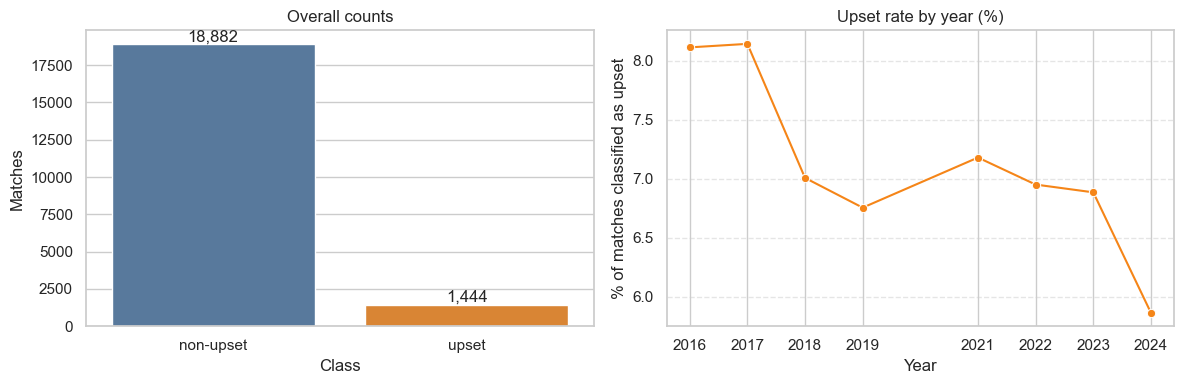

In [6]:
# Compute class distributions and visualize imbalance
assert 'df_all' in globals(), "Data not loaded. Please run the loading cell above."

# Overall distribution
overall_counts = df_all['upset_binary'].value_counts().sort_index()
overall_pct = df_all['upset_binary'].value_counts(normalize=True).sort_index() * 100
print("Overall class distribution:")
print(pd.DataFrame({
    'count': overall_counts,
    'percent': overall_pct.round(2)
}).rename(index={0:'non-upset',1:'upset'}))

# Per-year upset rate
per_year = (
    df_all.groupby('year')['upset_binary']
        .agg(upsets='sum', total='count')
        .assign(rate=lambda d: d['upsets'] / d['total'] * 100)
        .reset_index()
)
print("\nPer-year upset rate (%):")
print(per_year[['year','upsets','total','rate']])

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: overall counts
sns.barplot(x=['non-upset','upset'], y=overall_counts.values, ax=axes[0], palette=['#4C78A8','#F58518'])
axes[0].set_title('Overall counts')
axes[0].set_ylabel('Matches')
axes[0].set_xlabel('Class')
for i, v in enumerate(overall_counts.values):
    axes[0].text(i, v, f"{v:,}", ha='center', va='bottom')

# Right: per-year upset rate
sns.lineplot(data=per_year, x='year', y='rate', marker='o', ax=axes[1], color='#F58518')
axes[1].set_title('Upset rate by year (%)')
axes[1].set_ylabel('% of matches classified as upset')
axes[1].set_xlabel('Year')
axes[1].set_xticks(sorted(per_year['year'].unique()))
axes[1].grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

## Define time-aware train/val/test splits

We’ll use a leakage-safe, chronological split to mimic real forecasting:
- Train: 2016–2022
- Validation: 2023
- Test (final hold-out): 2024

We’ll report counts and upset rates per split to ensure distributions are sensible.

In [7]:
# Create chronological splits and check label distributions
assert 'df_all' in globals(), "Data not loaded. Please run the loading cell above."

TRAIN_YEARS = list(range(2016, 2023))  # 2016–2022
VAL_YEARS = [2023]
TEST_YEARS = [2024]

def split_by_year(df, years):
    return df[df['year'].isin(years)].copy()

def label_summary(df):
    counts = df['upset_binary'].value_counts().rename(index={0:'non-upset',1:'upset'})
    pct = df['upset_binary'].value_counts(normalize=True) * 100
    pct = pct.rename(index={0:'non-upset',1:'upset'})
    return pd.DataFrame({'count': counts, 'percent': pct.round(2)})

df_train = split_by_year(df_all, TRAIN_YEARS)
df_val   = split_by_year(df_all, VAL_YEARS)
df_test  = split_by_year(df_all, TEST_YEARS)

print(f"Train years: {TRAIN_YEARS}  | rows: {len(df_train):,}")
print(label_summary(df_train), end='\n\n')
print(f"Val years:   {VAL_YEARS}     | rows: {len(df_val):,}")
print(label_summary(df_val), end='\n\n')
print(f"Test years:  {TEST_YEARS}     | rows: {len(df_test):,}")
print(label_summary(df_test))

Train years: [2016, 2017, 2018, 2019, 2020, 2021, 2022]  | rows: 15,101
              count  percent
upset_binary                
non-upset     13990    92.64
upset          1111     7.36

Val years:   [2023]     | rows: 2,615
              count  percent
upset_binary                
non-upset      2435    93.12
upset           180     6.88

Test years:  [2024]     | rows: 2,610
              count  percent
upset_binary                
non-upset      2457    94.14
upset           153     5.86


## Baseline model: Logistic Regression with class weighting

We start with a simple, interpretable baseline that often performs well on imbalanced data:
- Preprocessing:
  - One-hot encode categorical features (handle unknowns).
  - Standardize numeric features and impute missing values.
- Model: Logistic Regression with `class_weight='balanced'` to counter class imbalance.
- Evaluation on validation split: PR-AUC (Average Precision), F1 (upset class), MCC, Balanced Accuracy, plus a confusion matrix at threshold 0.5.

We’ll exclude direct identifiers like `Winner`/`Loser` as features for generalization and to keep the feature space compact.

In [9]:
# Build preprocessing + logistic regression pipeline and evaluate on validation
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score, f1_score, matthews_corrcoef,
    balanced_accuracy_score, confusion_matrix, classification_report
)

# Define features
categorical_cols = ['Location','Tournament','Series','Court','Surface','Round']
numeric_cols = ['Best of','WRank','LRank','AvgW','AvgL','prob_winner','prob_loser']

# Prepare train/val datasets
X_train = df_train[categorical_cols + numeric_cols].copy()
y_train = df_train['upset_binary'].astype(int).values
X_val   = df_val[categorical_cols + numeric_cols].copy()
y_val   = df_val['upset_binary'].astype(int).values

# Preprocessing: impute + encode/scale
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))  # with_mean=False safe for sparse concat
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', numeric_transformer, numeric_cols),
], sparse_threshold=0.3)

clf = LogisticRegression(
    class_weight='balanced',
    solver='saga',
    max_iter=2000,
    n_jobs=None,
    random_state=SEED,
)

pipe = Pipeline(steps=[('prep', preprocessor), ('clf', clf)])

# Train
pipe.fit(X_train, y_train)

# Validate
probs_val = pipe.predict_proba(X_val)[:, 1]
preds_val = (probs_val >= 0.5).astype(int)  # default threshold (tune later)

metrics = {
    'PR-AUC (AP)': average_precision_score(y_val, probs_val),
    'F1 (upset)': f1_score(y_val, preds_val, pos_label=1),
    'MCC': matthews_corrcoef(y_val, preds_val),
    'Balanced Accuracy': balanced_accuracy_score(y_val, preds_val),
}

print("Validation metrics (default threshold 0.5):")
for k, v in metrics.items():
    print(f"- {k}: {v:.4f}")

cm = confusion_matrix(y_val, preds_val)
print("\nConfusion matrix (rows=true, cols=pred):\n", cm)

print("\nClassification report (val):")
print(classification_report(y_val, preds_val, target_names=['non-upset','upset']))

Validation metrics (default threshold 0.5):
- PR-AUC (AP): 0.9989
- F1 (upset): 0.9351
- MCC: 0.9322
- Balanced Accuracy: 0.9949

Confusion matrix (rows=true, cols=pred):
 [[2410   25]
 [   0  180]]

Classification report (val):
              precision    recall  f1-score   support

   non-upset       1.00      0.99      0.99      2435
       upset       0.88      1.00      0.94       180

    accuracy                           0.99      2615
   macro avg       0.94      0.99      0.96      2615
weighted avg       0.99      0.99      0.99      2615



## Baseline without odds features (market-agnostic)

To estimate predictive power beyond betting odds, we exclude `AvgW`, `AvgL`, `prob_winner`, and `prob_loser` and retrain the same class-weighted logistic regression.

In [10]:
# Train market-agnostic baseline and evaluate on validation
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score, f1_score, matthews_corrcoef,
    balanced_accuracy_score, confusion_matrix, classification_report
)

# Define features without odds-derived variables
categorical_no_odds = ['Location','Tournament','Series','Court','Surface','Round']
numeric_no_odds = ['Best of','WRank','LRank']  # exclude AvgW, AvgL, prob_winner, prob_loser

X_train_no = df_train[categorical_no_odds + numeric_no_odds].copy()
y_train_no = df_train['upset_binary'].astype(int).values
X_val_no   = df_val[categorical_no_odds + numeric_no_odds].copy()
y_val_no   = df_val['upset_binary'].astype(int).values

cat_tx = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])

num_tx = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])

prep_no = ColumnTransformer([
    ('cat', cat_tx, categorical_no_odds),
    ('num', num_tx, numeric_no_odds),
], sparse_threshold=0.3)

clf_no = LogisticRegression(
    class_weight='balanced',
    solver='saga',
    max_iter=2000,
    n_jobs=None,
    random_state=SEED,
)

pipe_no = Pipeline([('prep', prep_no), ('clf', clf_no)])
pipe_no.fit(X_train_no, y_train_no)

probs_val_no = pipe_no.predict_proba(X_val_no)[:, 1]
preds_val_no = (probs_val_no >= 0.5).astype(int)

metrics_no = {
    'PR-AUC (AP)': average_precision_score(y_val_no, probs_val_no),
    'F1 (upset)': f1_score(y_val_no, preds_val_no, pos_label=1),
    'MCC': matthews_corrcoef(y_val_no, preds_val_no),
    'Balanced Accuracy': balanced_accuracy_score(y_val_no, preds_val_no),
}

print("Validation metrics WITHOUT odds features (threshold 0.5):")
for k, v in metrics_no.items():
    print(f"- {k}: {v:.4f}")

cm_no = confusion_matrix(y_val_no, preds_val_no)
print("\nConfusion matrix (rows=true, cols=pred):\n", cm_no)

print("\nClassification report (val, no-odds):")
print(classification_report(y_val_no, preds_val_no, target_names=['non-upset','upset']))

Validation metrics WITHOUT odds features (threshold 0.5):
- PR-AUC (AP): 0.3805
- F1 (upset): 0.3708
- MCC: 0.3827
- Balanced Accuracy: 0.8277

Confusion matrix (rows=true, cols=pred):
 [[1934  501]
 [  25  155]]

Classification report (val, no-odds):
              precision    recall  f1-score   support

   non-upset       0.99      0.79      0.88      2435
       upset       0.24      0.86      0.37       180

    accuracy                           0.80      2615
   macro avg       0.61      0.83      0.63      2615
weighted avg       0.94      0.80      0.85      2615



## Threshold tuning on validation (odds-excluded baseline)

We sweep decision thresholds and pick the one that maximizes F1 for the upset class (the minority). We’ll also report precision, recall, balanced accuracy, and MCC at the chosen threshold and show a simple curve for context.

Best threshold by F1 (upset): 0.74
F1=0.4855 | Precision=0.4052 | Recall=0.6056 |  Balanced Acc=0.7699 | MCC=0.4499

Confusion matrix at best threshold (rows=true, cols=pred):
 [[2275  160]
 [  71  109]]


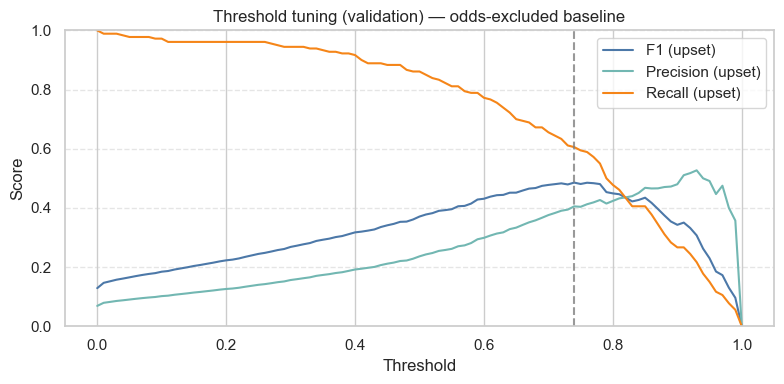

In [11]:
# Sweep thresholds to maximize F1 (upset) and visualize
from sklearn.metrics import precision_score, recall_score

assert 'probs_val_no' in globals(), "Run the odds-excluded baseline cell first."
assert 'y_val_no' in globals(), "Validation labels missing."

thresholds = np.linspace(0.0, 1.0, 101)
f1s, precs, recs, bals, mccs = [], [], [], [], []

for t in thresholds:
    preds = (probs_val_no >= t).astype(int)
    f1s.append(f1_score(y_val_no, preds, pos_label=1))
    precs.append(precision_score(y_val_no, preds, zero_division=0, pos_label=1))
    recs.append(recall_score(y_val_no, preds, pos_label=1))
    bals.append(balanced_accuracy_score(y_val_no, preds))
    mccs.append(matthews_corrcoef(y_val_no, preds))

best_idx = int(np.nanargmax(f1s))
best_t = thresholds[best_idx]

print(f"Best threshold by F1 (upset): {best_t:.2f}")
print(f"F1={f1s[best_idx]:.4f} | Precision={precs[best_idx]:.4f} | Recall={recs[best_idx]:.4f} | ",
      f"Balanced Acc={bals[best_idx]:.4f} | MCC={mccs[best_idx]:.4f}")

# Confusion matrix at best threshold
best_preds = (probs_val_no >= best_t).astype(int)
cm_best = confusion_matrix(y_val_no, best_preds)
print("\nConfusion matrix at best threshold (rows=true, cols=pred):\n", cm_best)

# Plot F1 / Precision / Recall vs threshold
plt.figure(figsize=(8,4))
plt.plot(thresholds, f1s, label='F1 (upset)', color='#4C78A8')
plt.plot(thresholds, precs, label='Precision (upset)', color='#72B7B2')
plt.plot(thresholds, recs, label='Recall (upset)', color='#F58518')
plt.axvline(best_t, color='gray', linestyle='--', alpha=0.8)
plt.title('Threshold tuning (validation) — odds-excluded baseline')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Apply tuned threshold on the test split (odds-excluded baseline)

We now evaluate the market-agnostic model on 2024 using the threshold selected on validation. This gives an unbiased estimate of generalization for the chosen operating point.

In [12]:
# Evaluate tuned threshold on test (2024)
from sklearn.metrics import average_precision_score

assert 'pipe_no' in globals(), "Train the no-odds pipeline first."
assert 'best_t' in globals(), "Run threshold tuning on validation first to set best_t."

X_test_no = df_test[categorical_no_odds + numeric_no_odds].copy()
y_test_no = df_test['upset_binary'].astype(int).values

probs_test_no = pipe_no.predict_proba(X_test_no)[:, 1]
preds_test_no = (probs_test_no >= best_t).astype(int)

metrics_test_no = {
    'PR-AUC (AP)': average_precision_score(y_test_no, probs_test_no),
    'F1 (upset)': f1_score(y_test_no, preds_test_no, pos_label=1),
    'MCC': matthews_corrcoef(y_test_no, preds_test_no),
    'Balanced Accuracy': balanced_accuracy_score(y_test_no, preds_test_no),
}

print(f"Test metrics at tuned threshold {best_t:.2f} (no-odds model):")
for k, v in metrics_test_no.items():
    print(f"- {k}: {v:.4f}")

cm_test_no = confusion_matrix(y_test_no, preds_test_no)
print("\nConfusion matrix (rows=true, cols=pred):\n", cm_test_no)

Test metrics at tuned threshold 0.74 (no-odds model):
- PR-AUC (AP): 0.2315
- F1 (upset): 0.3341
- MCC: 0.2928
- Balanced Accuracy: 0.6866

Confusion matrix (rows=true, cols=pred):
 [[2266  191]
 [  84   69]]


## Probability calibration (isotonic) for the odds-excluded model

We calibrate probabilities using isotonic regression on the validation set (cv='prefit'), then:
- Re-tune threshold on calibrated validation probs
- Evaluate calibrated model on the 2024 test set at the tuned threshold

Note: We reuse the trained no-odds pipeline as the base estimator for calibration; only probabilities are recalibrated.

Brier score (val, calibrated): 0.0481


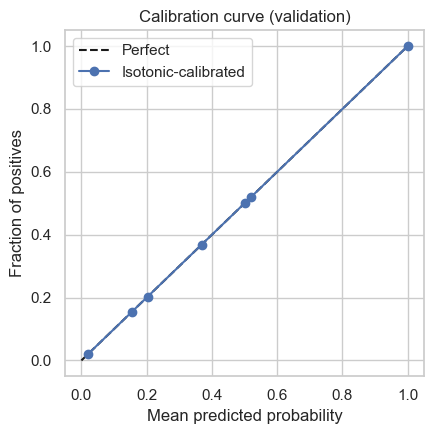

Best threshold by F1 after calibration: 0.21
F1=0.4930 | Precision=0.4240 | Recall=0.5889 |  Balanced Acc=0.7649 | MCC=0.4561


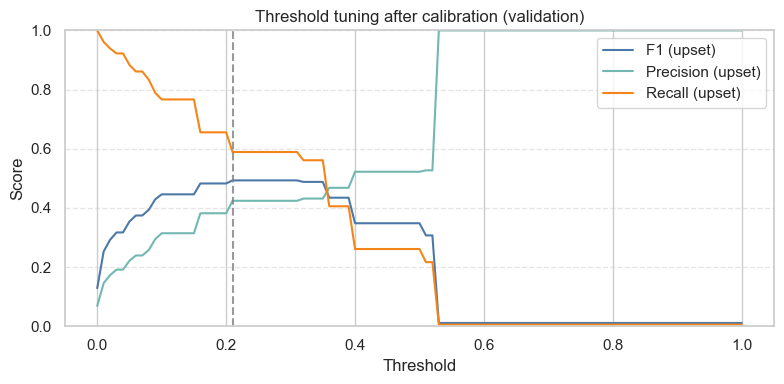

In [14]:
# Fit isotonic calibration on validation and re-evaluate
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss

assert 'pipe_no' in globals(), "Train the no-odds pipeline first."

# Calibrate using validation set (prefit base estimator)
calibrator = CalibratedClassifierCV(estimator=pipe_no, method='isotonic', cv='prefit')
calibrator.fit(X_val_no, y_val_no)

# Calibrated probabilities on validation
probs_val_no_cal = calibrator.predict_proba(X_val_no)[:, 1]
brier_val = brier_score_loss(y_val_no, probs_val_no_cal)
print(f"Brier score (val, calibrated): {brier_val:.4f}")

# (Optional) reliability curve data
frac_pos, mean_pred = calibration_curve(y_val_no, probs_val_no_cal, n_bins=10, strategy='uniform')
plt.figure(figsize=(4.5,4.5))
plt.plot([0,1],[0,1], 'k--', label='Perfect')
plt.plot(mean_pred, frac_pos, marker='o', label='Isotonic-calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration curve (validation)')
plt.legend()
plt.tight_layout()
plt.show()

# Re-run threshold sweep on calibrated probs
thresholds_cal = np.linspace(0.0, 1.0, 101)
f1s_cal, precs_cal, recs_cal, bals_cal, mccs_cal = [], [], [], [], []
for t in thresholds_cal:
    preds = (probs_val_no_cal >= t).astype(int)
    f1s_cal.append(f1_score(y_val_no, preds, pos_label=1))
    precs_cal.append(precision_score(y_val_no, preds, zero_division=0, pos_label=1))
    recs_cal.append(recall_score(y_val_no, preds, pos_label=1))
    bals_cal.append(balanced_accuracy_score(y_val_no, preds))
    mccs_cal.append(matthews_corrcoef(y_val_no, preds))

best_idx_cal = int(np.nanargmax(f1s_cal))
best_t_cal = thresholds_cal[best_idx_cal]

print(f"Best threshold by F1 after calibration: {best_t_cal:.2f}")
print(f"F1={f1s_cal[best_idx_cal]:.4f} | Precision={precs_cal[best_idx_cal]:.4f} | Recall={recs_cal[best_idx_cal]:.4f} | ",
      f"Balanced Acc={bals_cal[best_idx_cal]:.4f} | MCC={mccs_cal[best_idx_cal]:.4f}")

# Plot the tuned metrics vs threshold
plt.figure(figsize=(8,4))
plt.plot(thresholds_cal, f1s_cal, label='F1 (upset)', color='#4C78A8')
plt.plot(thresholds_cal, precs_cal, label='Precision (upset)', color='#72B7B2')
plt.plot(thresholds_cal, recs_cal, label='Recall (upset)', color='#F58518')
plt.axvline(best_t_cal, color='gray', linestyle='--', alpha=0.8)
plt.title('Threshold tuning after calibration (validation)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [15]:
# Evaluate calibrated model on test at tuned threshold
X_test_no = df_test[categorical_no_odds + numeric_no_odds].copy()
y_test_no = df_test['upset_binary'].astype(int).values

probs_test_no_cal = calibrator.predict_proba(X_test_no)[:, 1]
preds_test_no_cal = (probs_test_no_cal >= best_t_cal).astype(int)

metrics_test_no_cal = {
    'PR-AUC (AP)': average_precision_score(y_test_no, probs_test_no_cal),
    'F1 (upset)': f1_score(y_test_no, preds_test_no_cal, pos_label=1),
    'MCC': matthews_corrcoef(y_test_no, preds_test_no_cal),
    'Balanced Accuracy': balanced_accuracy_score(y_test_no, preds_test_no_cal),
    'Brier score': brier_score_loss(y_test_no, probs_test_no_cal),
}

print(f"Test metrics after calibration at tuned threshold {best_t_cal:.2f}:")
for k, v in metrics_test_no_cal.items():
    print(f"- {k}: {v:.4f}")

cm_test_no_cal = confusion_matrix(y_test_no, preds_test_no_cal)
print("\nConfusion matrix (rows=true, cols=pred):\n", cm_test_no_cal)

Test metrics after calibration at tuned threshold 0.21:
- PR-AUC (AP): 0.2287
- F1 (upset): 0.3342
- MCC: 0.2907
- Balanced Accuracy: 0.6754
- Brier score: 0.0517

Confusion matrix (rows=true, cols=pred):
 [[2291  166]
 [  89   64]]


## Boosted model (XGBoost) with class weighting — odds-excluded

We train a gradient-boosted tree model excluding odds-derived features, using class weighting via `scale_pos_weight` and early stopping on PR-AUC (Average Precision). We’ll:
- Preprocess with imputation + one-hot for categoricals (no leakage).
- Optimize with early stopping on the 2023 validation split.
- Tune the classification threshold on validation (F1 for upset).
- Evaluate on the 2024 test split at the tuned threshold.

scale_pos_weight: 12.59 (neg=13990, pos=1111)
Validation PR-AUC (AP): 0.5656
Best val threshold (XGB, F1 upset): 0.86
F1=0.5521 | Precision=0.5196 |  Recall=0.5889 | Balanced Acc=0.7743 |  MCC=0.5179

Validation confusion (rows=true, cols=pred):
 [[2337   98]
 [  74  106]]


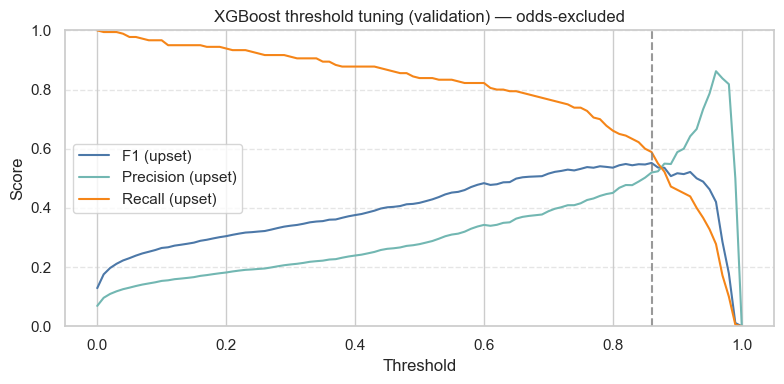


Test metrics (XGB, tuned threshold from val):
- PR-AUC (AP): 0.5449
- F1 (upset): 0.5044
- MCC: 0.4730
- Balanced Accuracy: 0.7603

Test confusion (rows=true, cols=pred):
 [[2355  102]
 [  67   86]]


In [18]:
# Train XGBoost (no-odds), threshold tune on val, evaluate on test
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    average_precision_score, f1_score, matthews_corrcoef,
    balanced_accuracy_score, confusion_matrix, precision_score, recall_score
)
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Features (reuse odds-excluded set)
categorical_no_odds = ['Location','Tournament','Series','Court','Surface','Round']
numeric_no_odds = ['Best of','WRank','LRank']

X_train_no = df_train[categorical_no_odds + numeric_no_odds].copy()
y_train_no = df_train['upset_binary'].astype(int).values
X_val_no   = df_val[categorical_no_odds + numeric_no_odds].copy()
y_val_no   = df_val['upset_binary'].astype(int).values
X_test_no  = df_test[categorical_no_odds + numeric_no_odds].copy()
y_test_no  = df_test['upset_binary'].astype(int).values

# Preprocessing for boosted model
cat_boost = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))
])
num_boost = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])
prep_boost = ColumnTransformer([
    ('cat', cat_boost, categorical_no_odds),
    ('num', num_boost, numeric_no_odds),
], sparse_threshold=0.3)

# Fit transform
X_train_b = prep_boost.fit_transform(X_train_no, y_train_no)
X_val_b   = prep_boost.transform(X_val_no)
X_test_b  = prep_boost.transform(X_test_no)

# Class weighting (neg/pos)
pos = y_train_no.sum()
neg = len(y_train_no) - pos
scale_pos_weight = (neg / pos) if pos > 0 else 1.0
print(f"scale_pos_weight: {scale_pos_weight:.2f} (neg={neg}, pos={pos})")

# XGBoost model (no early stopping to keep things simple/compatible)
xgb = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=1.0,
    tree_method='hist',
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    random_state=SEED,
    n_jobs=0,
)

xgb.fit(X_train_b, y_train_no)

# Validation evaluation
probs_val_xgb = xgb.predict_proba(X_val_b)[:, 1]
ap_val_xgb = average_precision_score(y_val_no, probs_val_xgb)
print(f"Validation PR-AUC (AP): {ap_val_xgb:.4f}")

# Threshold sweep (F1 for upset)
thresholds_xgb = np.linspace(0.0, 1.0, 101)
scores = {'t':[], 'f1':[], 'prec':[], 'rec':[], 'bal':[], 'mcc':[]}
for t in thresholds_xgb:
    preds = (probs_val_xgb >= t).astype(int)
    scores['t'].append(t)
    scores['f1'].append(f1_score(y_val_no, preds, pos_label=1))
    scores['prec'].append(precision_score(y_val_no, preds, zero_division=0, pos_label=1))
    scores['rec'].append(recall_score(y_val_no, preds, pos_label=1))
    scores['bal'].append(balanced_accuracy_score(y_val_no, preds))
    scores['mcc'].append(matthews_corrcoef(y_val_no, preds))

best_idx_xgb = int(np.nanargmax(scores['f1']))
best_t_xgb = scores['t'][best_idx_xgb]
print(f"Best val threshold (XGB, F1 upset): {best_t_xgb:.2f}")
print(
    f"F1={scores['f1'][best_idx_xgb]:.4f} | Precision={scores['prec'][best_idx_xgb]:.4f} | ",
    f"Recall={scores['rec'][best_idx_xgb]:.4f} | Balanced Acc={scores['bal'][best_idx_xgb]:.4f} | ",
    f"MCC={scores['mcc'][best_idx_xgb]:.4f}",
)

cm_val_xgb = confusion_matrix(y_val_no, (probs_val_xgb >= best_t_xgb).astype(int))
print("\nValidation confusion (rows=true, cols=pred):\n", cm_val_xgb)

# Plot F1/Precision/Recall vs threshold for XGB
plt.figure(figsize=(8,4))
plt.plot(thresholds_xgb, scores['f1'], label='F1 (upset)', color='#4C78A8')
plt.plot(thresholds_xgb, scores['prec'], label='Precision (upset)', color='#72B7B2')
plt.plot(thresholds_xgb, scores['rec'], label='Recall (upset)', color='#F58518')
plt.axvline(best_t_xgb, color='gray', linestyle='--', alpha=0.8)
plt.title('XGBoost threshold tuning (validation) — odds-excluded')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Test evaluation at tuned threshold
probs_test_xgb = xgb.predict_proba(X_test_b)[:, 1]
preds_test_xgb = (probs_test_xgb >= best_t_xgb).astype(int)
metrics_test_xgb = {
    'PR-AUC (AP)': average_precision_score(y_test_no, probs_test_xgb),
    'F1 (upset)': f1_score(y_test_no, preds_test_xgb, pos_label=1),
    'MCC': matthews_corrcoef(y_test_no, preds_test_xgb),
    'Balanced Accuracy': balanced_accuracy_score(y_test_no, preds_test_xgb),
}
print("\nTest metrics (XGB, tuned threshold from val):")
for k, v in metrics_test_xgb.items():
    print(f"- {k}: {v:.4f}")

cm_test_xgb = confusion_matrix(y_test_no, preds_test_xgb)
print("\nTest confusion (rows=true, cols=pred):\n", cm_test_xgb)